# NYU CUSP: Applied Data Science, Network Analysis
# Network visualization and basic analysis

In [2]:
#add necessary libraries
import numpy as np
import csv
import pandas as pd
import urllib2
import urllib
import json
from cStringIO import StringIO
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
#make sure plots are embedded into the notebook
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


## Network of County-to-County Migration in the US (2009- 2013)

In [3]:
migration_source = "https://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2013/county-to-county-migration-2009-2013/net_gross_us.txt"

In [9]:
migration_2014 = 'http://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2014/county-to-county-migration-2010-2014/county-to-county-migration-flows/Net_Gross_US.txt'

In [4]:
center_of_county_call = 'https://michellemho-carto.carto.com/api/v2/sql?q=select%20*%20from%20%22michellemho-carto%22.center_of_pop_county'

In [5]:
SQL_SOURCE = 'https://michellemho-carto.carto.com/api/v2/sql'

In [6]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except Exception:
        raise
    return StringIO(response.read())

In [7]:
countyQuery = '''
SELECT
    *
FROM center_of_pop_county
'''
countyStream = queryCartoDB(countyQuery, format='CSV')
county = pd.read_csv(countyStream)
county.head()

,cartodb_id,the_geom,the_geom_webmercator,fid,statefp,countyfp,couname,stname,latitude,longitude,state_county_fips
0,791,0101000020E61000003546EBA86AAD57C05A0EF450DB80...,0101000020110F0000EDE2EC8AF61B64C1B148843BD41F...,792,19,3,Adams,Iowa,41.006693,-94.709635,19003
1,2059,0101000020E610000065C746205E7754C0E3C5C2103925...,0101000020110F0000DEB01BEFCB6161C142ED2FE340B9...,2060,39,31,Coshocton,Ohio,40.290804,-81.865120,39031
2,836,0101000020E610000052EE3EC747E057C05F4205871732...,0101000020110F0000435FF761294764C1DD0A138C71E9...,837,19,93,Ida,Iowa,42.391343,-95.504381,19093
3,616,0101000020E61000007DE71725E81156C07ADCB75A27E2...,0101000020110F00002EAEE4B677BE62C144B1C3ECDC6E...,1,17,41,Douglas,Illinois,39.766826,-88.279794,17041
4,417,0101000020E610000007B47405DB4055C0DA696B4430A2...,0101000020110F000076A2C39AEB0C62C1DFD3A5E37358...,2,13,61,Clay,Georgia,31.633549,-85.013368,13061


In [10]:
county['state_county_fips'] = county['state_county_fips'].map(str)

In [11]:
county['state_county_fips'] = county.state_county_fips.apply(lambda x: x.zfill(6))

In [12]:
county.index = county.state_county_fips

In [13]:
#create a network with county names as nodes
Flights=nx.Graph()
Flights.add_nodes_from(county.index)

In [14]:
#create a dictionary of county locations
CountyPos={}
for c in county.index:
    CountyPos[c]=(county['longitude'][c],county['latitude'][c])

In [8]:
#now read the links
links = pd.read_csv(migration_source , index_col=None, header=None )
links.head()

,0
0,001001001003 Alabama Aut...
1,001001001005 Alabama Aut...
2,001001001007 Alabama Aut...
3,001001001009 Alabama Aut...
4,001001001011 Alabama Aut...


In [13]:
parser2={'Geography_A_fips':(0,6),
'Geography_B_fips':(6,12),
'Geography_A_state':(13,43),
'Geography_A_county':(43,78),
'Geography_B_state':(79,109),
'Geography_B_county':(109,144),
'Flow from Geography B to Geography A Estimate':(145,153),
'Flow from Geography B to Geography A MOE':(154,162),
'Counterflow from Geography A to Geography B Estimate':(163,171),
'Counterflow from Geography A to Geography B MOE':(172,180),
'Net Migration from Geography B to Geography A Estimate':(181,189),
'Net Migration from Geography B to Geography A MOE':(190,198),
'Gross Migration between Geography A and Geography B Estimate':(199,207),
'Gross Migration between Geography A and Geography B MOE':(208,216)}

In [17]:
dflinks = pd.DataFrame()
for i, j in parser2.iteritems():
    dflinks[i] = links[0].str.slice(j[0],j[1])

In [18]:
# This next part does two right joins of the "links" to "county" to remove places
#that we don't have points for (ie. Asia, Africa, Europe...)
dflinks.index = dflinks.Geography_B_fips

In [19]:
df2 = dflinks.join(county,how='right')

In [20]:
df2.index=df2.Geography_A_fips

In [21]:
df3 = df2.join(county,how='right',rsuffix='r_')

In [22]:
# create weighted edge list
EN=len(df3.index)
weighted_edgelist=[0]*EN
for j in range(0,EN):
    weighted_edgelist[j]=(df3['Geography_B_fips'][j],df3['Geography_A_fips'][j],float(df3['Flow from Geography B to Geography A Estimate'][j]))

In [23]:
Flights.add_weighted_edges_from(weighted_edgelist)

In [24]:
w=[d['weight'] for (u,v,d) in Flights.edges(data=True)]

In [25]:
dW = Flights.degree(weight='weight').values()

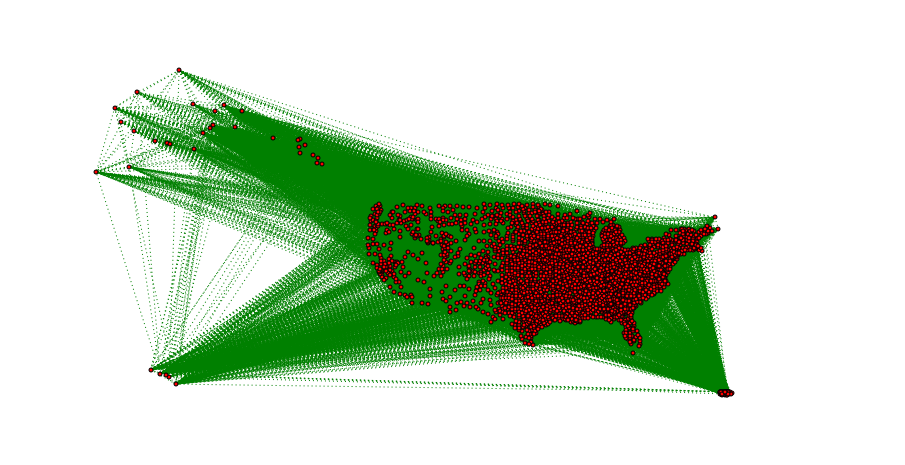

In [26]:
#visualize the network
plt.figure(figsize = (12,6))
nx.draw(Flights,pos=CountyPos,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)

In [27]:
#least connected county
j=np.argmin(dW)
print('Least connected county is {0}, {1} with {2} incoming migrants'.format(
        county.ix[Flights.degree().keys()[j]].couname,
        county.ix[Flights.degree().keys()[j]].stname,dW[j]))

Least connected county is Kalawao, Hawaii with 6.0 incoming migrants


In [29]:
F = Flights.degree(weight='weight')

In [34]:
dW.sort(reverse=True)

In [35]:
#Find top X most connected counties
X = 30
top = sorted(F, key=F.get, reverse=True)[:X]

for i in range(0,X):
    print('Number {0} county with highest influx is {1}, {2} with {3} connections and {4} incoming migrants'.format(i+1,
        county.ix[top[i]].couname,
        county.ix[top[i]].stname,
        Flights.degree()[top[i]],
        dW[i]))

Number 1 county with highest influx is Los Angeles, California with 1350 connections and 299729.0 incoming migrants
Number 2 county with highest influx is Cook, Illinois with 1337 connections and 184053.0 incoming migrants
Number 3 county with highest influx is Harris, Texas with 1231 connections and 176934.0 incoming migrants
Number 4 county with highest influx is Maricopa, Arizona with 1532 connections and 160474.0 incoming migrants
Number 5 county with highest influx is San Diego, California with 1270 connections and 135393.0 incoming migrants
Number 6 county with highest influx is Dallas, Texas with 1065 connections and 133935.0 incoming migrants
Number 7 county with highest influx is Orange, California with 845 connections and 130503.0 incoming migrants
Number 8 county with highest influx is San Bernardino, California with 837 connections and 118575.0 incoming migrants
Number 9 county with highest influx is Riverside, California with 806 connections and 113640.0 incoming migrants


In [10]:
links = pd.read_csv(migration_2014 , index_col=None, header=None )
links.head()

,0
0,001001001003 Alabama Aut...
1,001001001005 Alabama Aut...
2,001001001007 Alabama Aut...
3,001001001011 Alabama Aut...
4,001001001013 Alabama Aut...


In [14]:
dflinks = pd.DataFrame()
for i, j in parser2.iteritems():
    dflinks[i] = links[0].str.slice(j[0],j[1])

In [15]:
dflinks

,Geography_B_fips,Geography_B_county,Flow from Geography B to Geography A MOE,Flow from Geography B to Geography A Estimate,Geography_A_county,Geography_A_fips,Net Migration from Geography B to Geography A MOE,Geography_B_state,Gross Migration between Geography A and Geography B Estimate,Counterflow from Geography A to Geography B MOE,Counterflow from Geography A to Geography B Estimate,Geography_A_state,Net Migration from Geography B to Geography A Estimate,Gross Migration between Geography A and Geography B MOE
0,001003,Baldwin County,75,77,Autauga County,001001,102,Alabama,165,66,88,Alabama,-11,99
1,001005,Barbour County,8,4,Autauga County,001001,8,Alabama,4,21,0,Alabama,4,8
2,001007,Bibb County,27,0,Autauga County,001001,143,Alabama,141,143,141,Alabama,-141,143
3,001011,Bullock County,11,6,Autauga County,001001,16,Alabama,13,10,7,Alabama,-1,15
4,001013,Butler County,6,3,Autauga County,001001,6,Alabama,3,21,0,Alabama,3,6
5,001015,Calhoun County,27,0,Autauga County,001001,55,Alabama,47,55,47,Alabama,-47,55
6,001017,Chambers County,5,2,Autauga County,001001,5,Alabama,2,24,0,Alabama,2,5
7,001021,Chilton County,156,163,Autauga County,001001,156,Alabama,167,8,4,Alabama,159,155
8,001023,Choctaw County,27,0,Autauga County,001001,39,Alabama,29,39,29,Alabama,-29,39
9,001031,Coffee County,6,3,Autauga County,001001,45,Alabama,47,45,44,Alabama,-41,45
